In [1]:
import torch
from torch import nn
from helper import supress_tracer_warnings, assert_shape, is_list_of_str, normalise_2nd_moment

from typing import Optional, Any, List
import numpy as np
import matplotlib.pyplot as plt

from shared import FullyConnectedLayers

In [2]:
import sys
import os

cur_path = ''.join(os.getcwd().split('/')[:-1])
sys.path.insert(0, f'{cur_path}/torch_utils/ops')
sys.path.insert(0, f'{cur_path}/torch_utils')

In [3]:
import conv2d_resample
import upfirdn2d
import bias_act
import fma

In [4]:
def show_one(x: torch.Tensor):
    if x.ndim == 4:
        x = x[0]  # first batch
    assert x.shape[0] <= 4
    plt.imshow(x.permute(1,2,0).detach().cpu().numpy())

In [ ]:
def modulated_conv2d(x: torch.Tensor, weight: torch.Tensor, styles: torch.Tensor, noise: Optional[torch.Tensor] = None,
                     up: int = 1, down: int = 1, padding: int = 0, resample_filter: Optional[List[int]] = None, 
                     demodulate: bool = True, flip_weight: bool = True, fused_mod_cov: bool = True) -> torch.Tensor:
    
    # x:      [B, inC, H, W]
    # weight: [outC, inC, kh, kw]
    # styles: [B, inC]

    batch_size = x.shape[0]
    out_channels, in_channels, kw, kh = weight.shape
    assert_shape(weight, [out_channels, in_channels, kw, kh])
    assert_shape(x, [batch_size, in_channels, None, None])    # x's & weight's batch_size and In channels must remain same
    assert_shape(styles, [batch_size, in_channels])

    if x.dtype == torch.float16 and demodulate:
        a = 1 / np.sqrt(in_channels * kh * kw)
        b = weight.norm(p = float("inf"), dim = [1,2,3], keepdim=True)          # max of inC, kh, kw
        weight = weight * (a / b)

        styles = styles / styles.norm(p = float('inf'), dim = [1], keep_dim = True) # max of inC
    
    w = None
    dcoef = None
    if demodulate or fused_mod_cov:
        w = weight.unsqueeze(0)                                    # w:      [1, outC, inC, kh, kw]
        w = w * styles.reshape(batch_size, 1, -1, 1, 1)            # styles: [B,  1,   inC, 1,  1]
                                                                   # w:      [B, outC, inC, kh, kw]
    if demodulate:
        dcoef = (w.square().sum(dim=[2,3,4]) + 1e-8).rsqrt()       # dcoef:  [B, outC]
       
    if demodulate and fused_mod_cov:
        w = w * dcoef.reshape(batch_size, -1, 1, 1, 1)             # w:      [B, outC, inC, kh, kw]
         # w_hat_i = modulated_weight_i / sqrt(sum_j(modulated_weight_{i,j} ** 2) + epsilon)

    if not fused_mod_cov:
        x = x * styles.reshape(batch_size, -1, 1, 1)               # style: [B, inC x kh x kw, C, 1]
        x = conv2d_resample.conv2d_resample(x=x, w=weight.to(x.dtype), f=resample_filter, up=up, down=down, padding=padding, flip_weight=flip_weight)
        x = x.reshape(batch_size, -1, *x.shape[2:])

        if demodulate and noise is not None:
            x = fma.fma(x, dcoef.to(x.dtype).reshape(batch_size, -1, 1, 1), noise.to(x.dtype))
        elif demodulate:
            x = x * dcoef.to(x.dtype).reshape(batch_size, -1, 1, 1)
        elif noise is not None:
            x = x.add_(noise.to(x.dtype))                          # noise: [B, inC, H, W]                            
        return x
    
    # if fused_mod_cov is True
    # Execute as one fused op using grouped convolution.

    with supress_tracer_warnings(): # this value will be treated as a constant
        batch_size = int(batch_size)
    assert_shape(x, [batch_size, in_channels, None, None])

    x = x.reshape(1, -1, *x.shape[2:])                            # x: [1, B x inC, H, W]
    w = w.reshape(-1, in_channels, kh, kw)                        # w: [B x outC, inC, kh, kw]

    x = conv2d_resample.conv2d_resample(x=x, w=w.to(x.dtype), f=resample_filter, up=up, down=down, padding=padding, groups=batch_size, flip_weight=flip_weight)
    x = x.reshape(batch_size, -1, *x.shape[2:])                   # x: [B, C, H, W]
    if noise is not None:
        x = x.add_(noise)
    return x

In [6]:
batch = 5
height = 10
width = 10
in_channels = 3
out_channels = 6
kh = kw = 5

modulated_conv2d(
    x = torch.rand(batch, in_channels, height, width),
    weight = torch.rand(out_channels, in_channels, kh, kw),
    styles =  torch.rand(batch, in_channels),
    up = 3,
    fused_mod_cov = False,
    noise= torch.rand(batch, out_channels, 26, 26)
).shape

torch.Size([5, 6, 26, 26])

In [7]:
batch = 5
height = width = 10
width = 10
in_channels = 6
out_channels = 3
kh = kw = 1

modulated_conv2d(
    x = torch.rand(batch, in_channels, height, width),
    weight = torch.rand(out_channels, in_channels, kh, kw),
    styles =  torch.rand(batch, in_channels),
).shape

torch.Size([5, 3, 10, 10])

In [8]:
class GroupNorm_float32(nn.GroupNorm):
    def forward(self, x: torch.Tensor):
        return super().forward(x.float()).type(x.dtype) # Converts x to float32 -> applies Group norm -> converts back to original type

x = torch.randn(8, 32, 64, 64).half()  # float16 tensor

gn = GroupNorm_float32(num_groups=8, num_channels=32)
y = gn(x)
y.dtype

torch.float16

In [9]:
class StyleSplit(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        """
        •	Suppress or amplify features (gate)
        •	Scale them globally (scale)
        •	Shift them (bias)
        """
        super().__init__()

        self.fcl = FullyConnectedLayers(in_features=in_channels, out_features = 3*out_channels, **kwargs)
    
    def forward(self, x: torch.Tensor):
        x = self.fcl(x)
        m1, m2, m3 = x.chunk(chunks=3, dim=1)
        
        return m1 * m2 + m3 # scale . gate + bias

In [10]:
ss = StyleSplit(in_channels=512, out_channels=5)

x = torch.rand([10, 512])
ss(x).shape

torch.Size([10, 5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 100, 100])


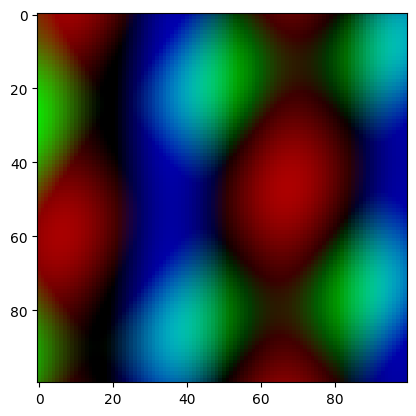

In [28]:
class SynthesisInput(nn.Module):
    """
    Latent w → SynthesisInput → Feature map [B, 64, 64, 64]

    sin(2pi (f . x + phi))
    
    Where:
	•	f = 2D frequency vector (learned)
	•	x = pixel location
	•	phi = phase offset (learned)
	•	All of this is modulated by latent vector w through an affine transformation
    """

    def __init__(self, w_dim: int, channels: int, size: int, sampling_rate: int, bandwidth: int):
        super().__init__()

        self.w_dim = w_dim
        self.channels = channels
        self.size = np.broadcast_to(size, [2])
        self.sampling_rate = sampling_rate
        self.bandwidth = bandwidth

        # Draw random frequencies from uniform 2D disc.
        freqs = torch.rand([self.channels, 2])                      # Gausian Cloud in 2D space
        radii = freqs.square().sum(dim = 1, keepdim=True).sqrt()    # r = sqrt(x^2 + y^2)
        freqs = freqs / (radii * radii.square().exp().pow(0.25))    # freqs = freqs / r x exp(0.25 x r^2)}
        freqs *= bandwidth
        phases = torch.rand([self.channels]) - 0.5                  # values are in range [-0.5, 0.5]

        self.weights = nn.Parameter(torch.randn([self.channels, self.channels]))
        self.affine = FullyConnectedLayers(in_features=w_dim, 
                                           out_features=4,
                                           weight_init = 0,
                                           bias_init=[1,0,0,0])
        
        self.register_buffer("transforms", torch.eye(3,3))
        self.register_buffer("freqs", freqs)
        self.register_buffer("phases", phases)

    def forward(self, w: torch.Tensor): 
        # w = [B, w_dim]
        transforms = self.transforms.unsqueeze(0)                                   # [batch, row, col]
        freqs = self.freqs.unsqueeze(0)                                             # [batch, channels, 2] since 2D space, xy
        phases = self.phases.unsqueeze(0)                                           # [batch, channels]

        t = self.affine(w)                                                          # t: [batch, 4]
        t = t / t[:, :2].norm(dim = 1, keepdim = True)                              # t: [batch, 4] / [5, 1] -> [batch, 4]

        m_r = torch.eye(3, device=w.device).unsqueeze(0).repeat([w.shape[0], 1, 1]) # m_r = [batch, 3, 3] Identity matrix     ROTATION
        m_r[:, 0, 0] = t[:, 0]  # r'_c
        m_r[:, 0, 1] = -t[:, 1] # r'_s
        m_r[:, 1, 0] = t[:, 1]  # r'_s
        m_r[:, 1, 1] = t[:, 0]  # r'_c

        # m_r:
        # [cos(theta)  -sin(theta)  0]
        # [sin(theta)   cos(theta)  0]
        # [0            0           1]

        m_t = torch.eye(3, device=w.device).unsqueeze(0).repeat([w.shape[0], 1, 1]) # m_t = [batch, 3, 3] Identity matrix     TRANSFORM
        m_t[:, 0, 2] = -t[:, 2] # t'_x
        m_t[:, 1, 2] = -t[:, 3] # t'_y
        # m_t:
        # [1  0  -tx]
        # [0  1  -ty]
        # [0  0    1]

        transforms = m_r @ m_t @ transforms # First rotate resulting image, then translate, and finally apply user-specified transform.
        # transforms: [batch, 3, 3]

        phases = phases + (freqs @ transforms[:, :2, 2:]).squeeze(2)
        freqs = freqs @ transforms[:, :2, :2]

        # Dampen out-of-band frequencies that may occur due to the user-specified transform.
        amplitudes = (1 - (freqs.norm(dim=2) - self.bandwidth) / (self.sampling_rate / 2 - self.bandwidth)).clamp(0, 1)
        
        theta = torch.eye(2, 3)
        theta[0, 0] = 0.5 * self.size[0] / self.sampling_rate
        theta[1, 1] = 0.5 * self.size[1] / self.sampling_rate

        grids = torch.nn.functional.affine_grid(theta.unsqueeze(0), [1, 1, self.size[1], self.size[0]], align_corners=False)  # [1, size, size, 2]
        
        # Compute Fourier features.
        x = (grids.unsqueeze(3) @ freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)).squeeze(3) # [batch, height, width, channel]
        x = x + phases.unsqueeze(1).unsqueeze(2)
        x = torch.sin(x * (np.pi * 2))
        x = x * amplitudes.unsqueeze(1).unsqueeze(2)

        # Apply trainable mapping.
        weight = self.weights / np.sqrt(self.channels)
        x = x @ weight.t()

        # Ensure correct shape.
        x = x.permute(0, 3, 1, 2) # [batch, channel, height, width]
        assert_shape(x, [w.shape[0], self.channels, int(self.size[1]), int(self.size[0])])
        return x.contiguous()

    def extra_repr(self) -> str:
        return '\n'.join([
            f'w_dim={self.w_dim:d}, channels={self.channels:d}, size={list(self.size)},',
            f'sampling_rate={self.sampling_rate:g}, bandwidth={self.bandwidth:g}'])
    
si = SynthesisInput(w_dim=512, channels=3, size = 100, sampling_rate = 100, bandwidth=2)

out = si(torch.rand(5, 512))
print(out.shape)
show_one(out)

In [12]:
bias_def_gain = {"linear": 1,
 "relu": 1.4142135623730951,
 "lrelu": 1.4142135623730951,
 "tanh": 1,
 "sigmoid": 1,
 "elu": 1,
 "selu": 1,
 "softplus": 1,
 "swish": "1.4142135623730951"}

In [13]:
class SynthesisLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, w_dim: int, resolution: int, kernel_size: int = 3, up: int = 1,
                 use_noise: bool = True,                    # Enable noise input?
                 acivation: str = "lrelu",                  # Activation function: 'relu', 'lrelu', etc.
                 resample_filer: List[int] = [1, 3, 3, 1],  # Low-pass filter to apply when resampling activations.
                 conv_clamp: Optional[int] = None,          # Clamp the output of convolution layers to +-X, None = disable clamping.
                 channels_last: bool = False,               # Use channels_last format for the weights?
                 layer_scale_init: float = 1e-5,            # Initial value of layer scale.
                 residual: bool = False,                    # Residual convolution?
                 gn_groups: int = 32,                       # Number of groups for GroupNorm
                 ):
        super().__init__()

        if residual: assert in_channels == out_channels
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.w_dim = w_dim
        self.resolution = resolution
        self.kernel_size = kernel_size
        self.use_noise = use_noise
        self.acivation = acivation
        self.conv_clamp = conv_clamp
        self.residual = residual
        self.up = up
        self.register_buffer("resample_filer", upfirdn2d.setup_filter(resample_filer))
        self.padding = kernel_size // 2
        self.act_gain = bias_def_gain[acivation]

        if use_noise:
            self.register_buffer("noise_const", torch.randn([resolution, resolution]))
            self.noise_strength = nn.Parameter(torch.zeros([]))

        self.affine = StyleSplit(
            in_channels = w_dim,
            out_channels = in_channels,
            bias_init = 1
        )

        memory_format = torch.channels_last if channels_last else torch.contiguous_format
        # contiguous_format |   [N, C, H, W]  |  Default, works everywhere
        # channels_last     |   [N, H, W, C]  |  Faster on GPUs with mixed-precision (AMP)

        self.weight = nn.Parameter(
            torch.randn([
                out_channels, in_channels, kernel_size, kernel_size
                ])
        ).to(memory_format = memory_format)
        
        self.bias = nn.Parameter(torch.zeros([out_channels]))

        if self.residual:
            assert up == 1
            self.norm = GroupNorm_float32(gn_groups, out_channels)
            self.gamma = nn.Parameter(layer_scale_init * torch.ones([1, out_channels, 1, 1])).to(memory_format = memory_format)    # gamma: [1, OutC, 1, 1]
            
    def forward(self, x: torch.Tensor, w: torch.Tensor, noise_mode: str = 'random', fused_mod_cov: bool = True, gain: int = 2):
        in_resolution = self.resolution // self.up
        assert_shape(x, [None, self.in_channels, in_resolution, in_resolution])

        noise = None
        if self.use_noise and noise_mode == "random":
            noise = torch.randn([x.shape[0], 1, self.resolution, self.resolution],  device=x.device) * self.noise_strength
        if self.use_noise and noise_mode == 'const':
            noise = self.noise_const * self.noise_strength
        
        flip_weight = (self.up == 1)  
        styles = self.affine(w)

        if self.residual: x = self.norm(x)
        y = modulated_conv2d(x=x, weight=self.weight, styles=styles, noise=noise, up=self.up, fused_mod_cov=fused_mod_cov,
                            padding=self.padding, resample_filter=self.resample_filer, flip_weight=flip_weight)
        y = y.to(x.dtype)

        act_gain = self.act_gain * gain
        act_clamp = self.conv_clamp * gain if self.conv_clamp is not None else None

        y = bias_act.bias_act(y, self.bias.to(x.dtype), act=self.acivation, gain=act_gain, clamp=act_clamp)

        if self.residual:
            y = self.gamma * y
            y = y.to(x.dtype).add_(x).mul(np.sqrt(2))
        
        return y
        
    def extra_repr(self) -> str:
        return ' '.join([
            f'in_channels={self.in_channels:d}, out_channels={self.out_channels:d}, w_dim={self.w_dim:d},',
            f'resolution={self.resolution:d}, up={self.up}, activation={self.acivation:s}'])

sl = SynthesisLayer(in_channels=5, out_channels=10, w_dim=512, resolution=128)
sl

SynthesisLayer(
  in_channels=5, out_channels=10, w_dim=512, resolution=128, up=1, activation=lrelu
  (affine): StyleSplit(
    (fcl): FullyConnectedLayers(
      In Features: 512
      Out Features: 15
      Activation Function: linear
    )
  )
)

In [14]:
batch = 5
height = width = 100
in_channels = 32
out_channels = 32
kh = kw = 5
w_dim = 512
resolution = 100

sl = SynthesisLayer(in_channels=in_channels, out_channels=out_channels, w_dim=w_dim, resolution=resolution, residual=True)

x = torch.rand(batch, in_channels, height, width)
weight = torch.rand(batch, w_dim)

out = sl(x, weight)
out.shape

torch.Size([5, 32, 100, 100])

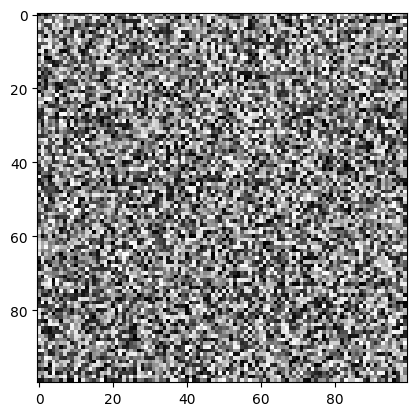

In [15]:
plt.imshow(out[0][0][:, :, None].detach().numpy(), cmap="gray")

In [16]:
class ToRGBLayer(nn.Module):
    """
    Last layer that converts feature vector to rgb image: [B, 3, H, W]
    """

    def __init__(self, in_channels: int, out_channels: int, w_dim: int, kernel_size: int = 1, conv_clamp: Optional[int] = None, channels_last: bool = False):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.w_dim = w_dim
        self.conv_clamp = conv_clamp
        self.affine = StyleSplit(
            in_channels = w_dim,
            out_channels = in_channels,
            bias_init = 1
        )

        memory_format = torch.channels_last if channels_last else torch.contiguous_format
        self.weight = nn.Parameter(0.1 * torch.randn([self.out_channels, self.in_channels, kernel_size, kernel_size])).to(memory_format = memory_format) 
        self.bias = nn.Parameter(torch.zeros([out_channels]))
        self.weight_gain = 1 / np.sqrt(in_channels * (kernel_size**2))

    def forward(self, x: torch.Tensor, w: torch.Tensor, fused_mod_cov: bool = True) -> torch.Tensor:
                                                                                          # x:      [B, Cs, H, W]
                                                                                          # w:      [B, w_dim]
        styles = self.affine(w) * self.weight_gain                                        # styles: [B, inC]
        x = modulated_conv2d(x = x, weight=self.weight, styles=styles, demodulate=False)  # x:      [B, outC, H, W]
        x = bias_act.bias_act(x, self.bias.to(x.dtype), clamp=self.conv_clamp)
        return x

    def extra_repr(self) -> str:
        return f'in_channels={self.in_channels:d}, out_channels={self.out_channels:d}, w_dim={self.w_dim:d}'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 128, 128])


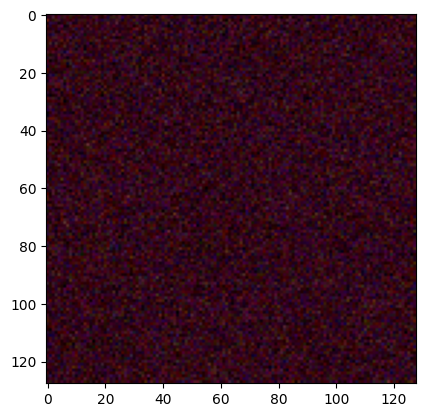

In [25]:
x = torch.rand(5, 64, 128, 128)
w = torch.rand(5, 512)

torgblayer = ToRGBLayer(in_channels=64, out_channels=3, w_dim=512)
out = torgblayer(x, w)
print(out.shape)

show_one(out[1])

In [ ]:
class SynthesisBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, w_dim: int, resolution: int, img_channels: int,
                 is_last: bool,                                  # Is this the last block?
                 num_res_blocks: int = 3,                        # Number of conv layers per block
                 architecture: str = "orig",                     # Architecture: 'orig', 'skip'.
                 resample_filter: list[int] = [1,3,3,1],         # Low-pass filter to apply when resampling activations.
                 conv_clamp: int = 256,                          # Clamp the output of convolution layers to +-X, None = disable clamping.
                 use_fp16: bool = False,                         # Use FP16 for this block?
                 fp16_channels_last: bool = False,               # Use channels-last memory format with FP16?
                 fused_modconv_default: Any = 'inference_only',  # Default value of fused_modconv.
                 **layer_kwargs,                                 # Arguments for SynthesisLayer.
                 ):
        super().__init__()

        assert architecture in ['orig', 'skip'], f"{architecture} not defined."

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.w_dim = w_dim
        self.resolution = resolution
        self.img_channels = img_channels
        self.is_last = is_last
        self.architecture = architecture
        self.use_fp16 = use_fp16
        self.fused_modconv_default = fused_modconv_default
        
        self.channels_last = (use_fp16 and fp16_channels_last)
        self.register_buffer('resample_filter', upfirdn2d.setup_filter(resample_filter))
        self.num_conv = 0
        self.num_torgb = 0

        if in_channels == 0:
            self.input = SynthesisInput(w_dim = self.w_dim, channels = self.out_channels, size = resolution, sampling_rate = resolution, bandwidth = 2)
            # input: [B, outC, resolution, resolution])
            self.num_conv += 1
        
        if in_channels != 0:
            self.conv0 = SynthesisLayer(in_channels = in_channels, out_channels = out_channels, w_dim = self.w_dim, resolution = resolution,
                                        up = 2, resample_filer = resample_filter, conv_clamp = conv_clamp, channels_last = self.channels_last, **layer_kwargs)
            # conv0: [B, outC, resolution, resolution]
            self.num_conv += 1
        
        convs = []
        for _ in range(num_res_blocks):
            convs.append(
                SynthesisLayer(in_channels = out_channels, out_channels = out_channels, resolution = resolution, conv_clamp = conv_clamp, 
                               channels_last = self.channels_last, w_dim = w_dim, **layer_kwargs)
            )
            convs.append(
                SynthesisLayer(in_channels = out_channels, out_channels = out_channels, resolution = resolution, conv_clamp = conv_clamp, 
                               channels_last = self.channels_last, w_dim = w_dim, **layer_kwargs, residual = True)
            )
        
        self.convs1 = nn.ModuleList(convs)
        self.num_conv += len(convs)

        if is_last or architecture == 'skip':
            self.torgb = ToRGBLayer(out_channels, img_channels, w_dim=w_dim,
                conv_clamp=conv_clamp, channels_last=self.channels_last)
            self.num_torgb += 1
    
    def forward(self, x: torch.Tensor, img: Optional[torch.Tensor], ws: torch.Tensor, force_fp32: bool = False, fused_mod_cov: bool = True, **layer_kwargs):
        w_iter = iter(ws.unbind(dim=1)) # ws: [B, num w, w_dim]
        if ws.device.type != "cuda": 
            force_fp32 = True
        dtype = torch.float16 if self.use_fp16 and not force_fp32 else torch.float32                                # use float16 is 'cpu' and use_fp16 is True
        memory_format = torch.channels_last if self.channels_last and not force_fp32 else torch.contiguous_format   # Channel last if 'cpu' and channel_last
        
        if fused_mod_cov is None:
            fused_mod_cov = self.fused_modconv_default
        if fused_mod_cov == "inference_only":
            fused_mod_cov = (not self.training)
        
        # Input
        if self.in_channels == 0:
            x = self.input(next(x)) # x: [B, w_dim]
        else:
            assert_shape(x, [None, self.in_channels, self.resolution//2, self.resolution//2])
        x = x.to(dtype=dtype, memory_format=memory_format)

        # Main Layers
        if self.in_channels == 0:
            for conv in self.conv1:
                x = conv(x, next(w_iter), fused_mod_cov = fused_mod_cov, gain = np.sqrt(0.5), **layer_kwargs)    # x: [B, outC, resolution, resolution]
        else:
            x = self.conv0(x, next(w_iter), fused_mod_cov = fused_mod_cov, **layer_kwargs)                       # x: [B, outC, resolution, resolution]
            for conv in self.convs1:
                x = conv(x, next(w_iter), fused_mod_cov = fused_mod_cov, gain=np.sqrt(0.5), **layer_kwargs)
        # x: [B, outC, resolution // 2, resolution // 2]
    
        # ToRGB
        if img is not None:
            assert_shape(img, [None, self.img_channels, self.resolution//2, self.resolution//2])
            img = upfirdn2d.upsample2d(img, self.resample_filter)      # img: [B, imgC, resolution, resolution] Doubles the H and W
        
        if self.is_last and self.architecture == "skip":
            y = self.torgb(x, next(w_iter), fused_mod_cov = fused_mod_cov)
            y = y.to(dtype=torch.float32, memory_format=torch.contiguous_format)
            img = img.add_(y) if img is not None else y

        assert x.dtype == dtype
        assert img is None or img.dtype == torch.float32
        return x, img

    def extra_repr(self) -> str:
        return f'resolution={self.resolution:d}, architecture={self.architecture:s}'


In [23]:
in_channels = 64
out_channels = 128
w_dim = 512
resolution = 128
img_channels = 3
batch = 5

sb = SynthesisBlock(in_channels = in_channels, out_channels = out_channels, w_dim = w_dim, resolution = resolution, img_channels = img_channels, is_last = True)

x = torch.rand(batch, in_channels, resolution // 2, resolution // 2)
img = torch.rand(batch, img_channels, resolution // 2, resolution // 2)
ws = torch.rand(batch, sb.num_conv + sb.num_torgb, w_dim)

out = sb(x, img, ws)
out[0].shape, out[1].shape

(torch.Size([5, 128, 128, 128]), torch.Size([5, 3, 128, 128]))

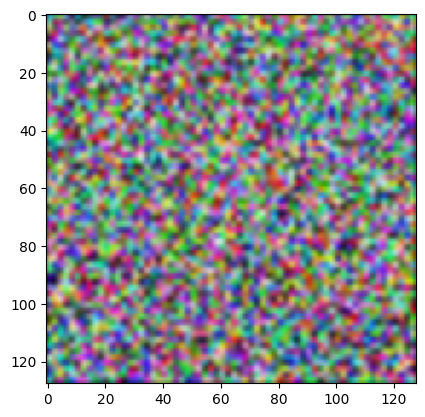

In [24]:
show_one(out[1])

In [21]:
iter(torch.rand(2, 3, 512).unbind(dim=1))

In [22]:
bias_act.bias_act(torch.rand(5, 3, 100, 100), bias)

NameError: name 'bias' is not defined

In [ ]:
nn.Parameter(torch.zeros([3]))

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

In [ ]:
layer_scale_init = 1e-5
nn.Parameter(layer_scale_init * torch.ones([1, out_channels, 1, 1]))

Parameter containing:
tensor([[[[1.0000e-05]],

         [[1.0000e-05]],

         [[1.0000e-05]],

         [[1.0000e-05]],

         [[1.0000e-05]],

         [[1.0000e-05]]]], requires_grad=True)

In [ ]:
nn.Parameter(
            torch.randn([
                out_channels, in_channels, kh, kw
                ])
        ).to(memory_format = torch.contiguous_format).shape

torch.Size([6, 3, 5, 5])

In [ ]:
bias_act.activation_funcs

{'linear': {'func': <function bias_act.<lambda>(x, **_)>,
  'def_alpha': 0,
  'def_gain': 1,
  'cuda_idx': 1,
  'ref': '',
  'has_2nd_grad': False},
 'relu': {'func': <function bias_act.<lambda>(x, **_)>,
  'def_alpha': 0,
  'def_gain': 1.4142135623730951,
  'cuda_idx': 2,
  'ref': 'y',
  'has_2nd_grad': False},
 'lrelu': {'func': <function bias_act.<lambda>(x, alpha, **_)>,
  'def_alpha': 0.2,
  'def_gain': 1.4142135623730951,
  'cuda_idx': 3,
  'ref': 'y',
  'has_2nd_grad': False},
 'tanh': {'func': <function bias_act.<lambda>(x, **_)>,
  'def_alpha': 0,
  'def_gain': 1,
  'cuda_idx': 4,
  'ref': 'y',
  'has_2nd_grad': True},
 'sigmoid': {'func': <function bias_act.<lambda>(x, **_)>,
  'def_alpha': 0,
  'def_gain': 1,
  'cuda_idx': 5,
  'ref': 'y',
  'has_2nd_grad': True},
 'elu': {'func': <function bias_act.<lambda>(x, **_)>,
  'def_alpha': 0,
  'def_gain': 1,
  'cuda_idx': 6,
  'ref': 'y',
  'has_2nd_grad': True},
 'selu': {'func': <function bias_act.<lambda>(x, **_)>,
  'def_alpha

In [ ]:
upfirdn2d.setup_filter([1,3,3,1])

tensor([[0.0156, 0.0469, 0.0469, 0.0156],
        [0.0469, 0.1406, 0.1406, 0.0469],
        [0.0469, 0.1406, 0.1406, 0.0469],
        [0.0156, 0.0469, 0.0469, 0.0156]])

In [ ]:
freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2).shape

torch.Size([5, 1, 1, 2, 64])

In [ ]:
theta = torch.eye(2, 3)
theta[0, 0] = 0.5 * 64 / 100
theta

tensor([[0.3200, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000]])

In [ ]:
grids = torch.nn.functional.affine_grid(theta.unsqueeze(0), [1, 1, 64, 64], align_corners=False)
grids.shape

torch.Size([1, 64, 64, 2])

In [ ]:
x = grids.unsqueeze(3) @ freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)
x.shape

torch.Size([5, 64, 64, 1, 64])

In [ ]:
transforms = torch.eye(3,3)
transforms = transforms @ torch.rand(5, 3, 3) @ torch.rand(5, 3, 3)
transforms.shape

torch.Size([5, 3, 3])

In [ ]:
transforms[:, :2, 2:].squeeze(2).shape

torch.Size([5, 2])

In [ ]:
freqs = torch.rand(5, 64, 2)
freqs = (freqs @ transforms[:, :2, 2:]).squeeze(2)
freqs.shape

torch.Size([5, 64])

In [ ]:
t = torch.rand(5, 4)
t = (t / t[:, :2].norm(dim = 1, keepdim = True))
t.shape

torch.Size([5, 4])

In [ ]:
m_r = torch.rand([1,3,3]).repeat([5,1,1])
m_r.shape

torch.Size([5, 3, 3])

In [ ]:
m_r

tensor([[[0.8165, 0.5862, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]],

        [[0.8165, 0.5862, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]],

        [[0.8165, 0.5862, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]],

        [[0.8165, 0.5862, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]],

        [[0.8165, 0.5862, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]]])

In [ ]:
t[:, 0]

tensor([0.9701, 0.4246, 0.9986, 0.9947, 0.8843])

In [ ]:
m_r[:, 0, 1] = t[:, 0]
m_r

tensor([[[0.8165, 0.9701, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]],

        [[0.8165, 0.4246, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]],

        [[0.8165, 0.9986, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]],

        [[0.8165, 0.9947, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]],

        [[0.8165, 0.8843, 0.2201],
         [0.0698, 0.9592, 0.1900],
         [0.0025, 0.8506, 0.8935]]])

In [ ]:
a.norm(dim = 1, keepdim = True)

NameError: name 'a' is not defined

In [ ]:
torch.eye(5,3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
freqs = torch.rand([3, 2]) # Gausian Cloud in 2D space
freqs

tensor([[0.4917, 0.4293],
        [0.2333, 0.6255],
        [0.3529, 0.9713]])

In [ ]:
radii = freqs.square().sum(dim = 1, keepdim=True).sqrt()
radii

tensor([[0.6527],
        [0.6676],
        [1.0335]])

In [ ]:
freqs / (radii * radii.square().exp().pow(0.25))

tensor([[0.6772, 0.5912],
        [0.3126, 0.8382],
        [0.2615, 0.7196]])